In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

TRAIN_MODE = True

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
%ls ./checkpoints

7class/                                  fasterrcnn_04161846_0.3716097325899753
cars/                                    fasterrcnn_04161926_0.392679008229772
cars_vans/                               fasterrcnn_04161946_0.3968523600547136
fasterrcnn_04161707_0.22845162333486074  fasterrcnn_04162005_0.4091784270985763
fasterrcnn_04161727_0.3320297390308642   fasterrcnn_04162045_0.4105527015235588
fasterrcnn_04161747_0.3345493470516339   vgg16_caffe.pth
fasterrcnn_04161807_0.349991486173056    VOC_weights/
fasterrcnn_04161826_0.3601753947130337


In [4]:
trainer.load('./checkpoints/fasterrcnn_04162045_0.4105527015235588')

In [7]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

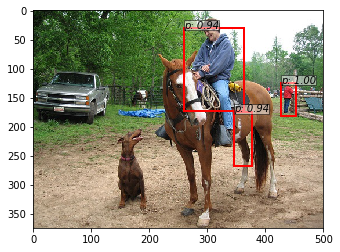

In [8]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [9]:
import os

dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

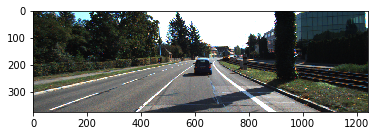

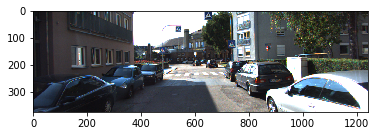

In [10]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Train mahalanobis features with entire training dataset

In [12]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader

print('load data')

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

    with open('kitti_features.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.features, f)

    with open('mahal_means.pickle', 'wb') as f:
        pickle.dump(mahal_means, f)

    with open('mahal_cov.pickle', 'wb') as f:
        pickle.dump(mahal_cov, f)

    with open('inv_mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

else:
    with open('kitti_features.pickle', 'rb') as f:
        trainer.faster_rcnn.features = pickle.load(f)

    with open('mahal_means.pickle', 'rb') as f:
        mahal_means = pickle.load(f)
        trainer.faster_rcnn.mahal_means = mahal_means

    with open('mahal_cov.pickle', 'rb') as f:
        mahal_cov = pickle.load(f)
        trainer.faster_rcnn.mahal_cov = mahal_cov

    with open('inv_mahal_cov.pickle', 'rb') as f:
        inv_mahal_cov = pickle.load(f)
        trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

  0%|          | 0/3012 [00:00<?, ?it/s]

load data
extracting features


100%|██████████| 3012/3012 [08:57<00:00,  5.96it/s]


calculating feature means
calculating feature covariance
inverting feature covariance


In [13]:
from tqdm import tqdm

if TRAIN_MODE:
    with open('gt_labels.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [14]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 656
van count: 290
truck count: 0
tram count: 0
person count: 0
person_sitting count: 0
cyclist count: 0
misc count: 0


# Visualize features using t-SNE

In [15]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open("tsne_features.pickle", "wb") as f:
        pickle.dump(X_tsne, f)

Computing t-SNE embedding


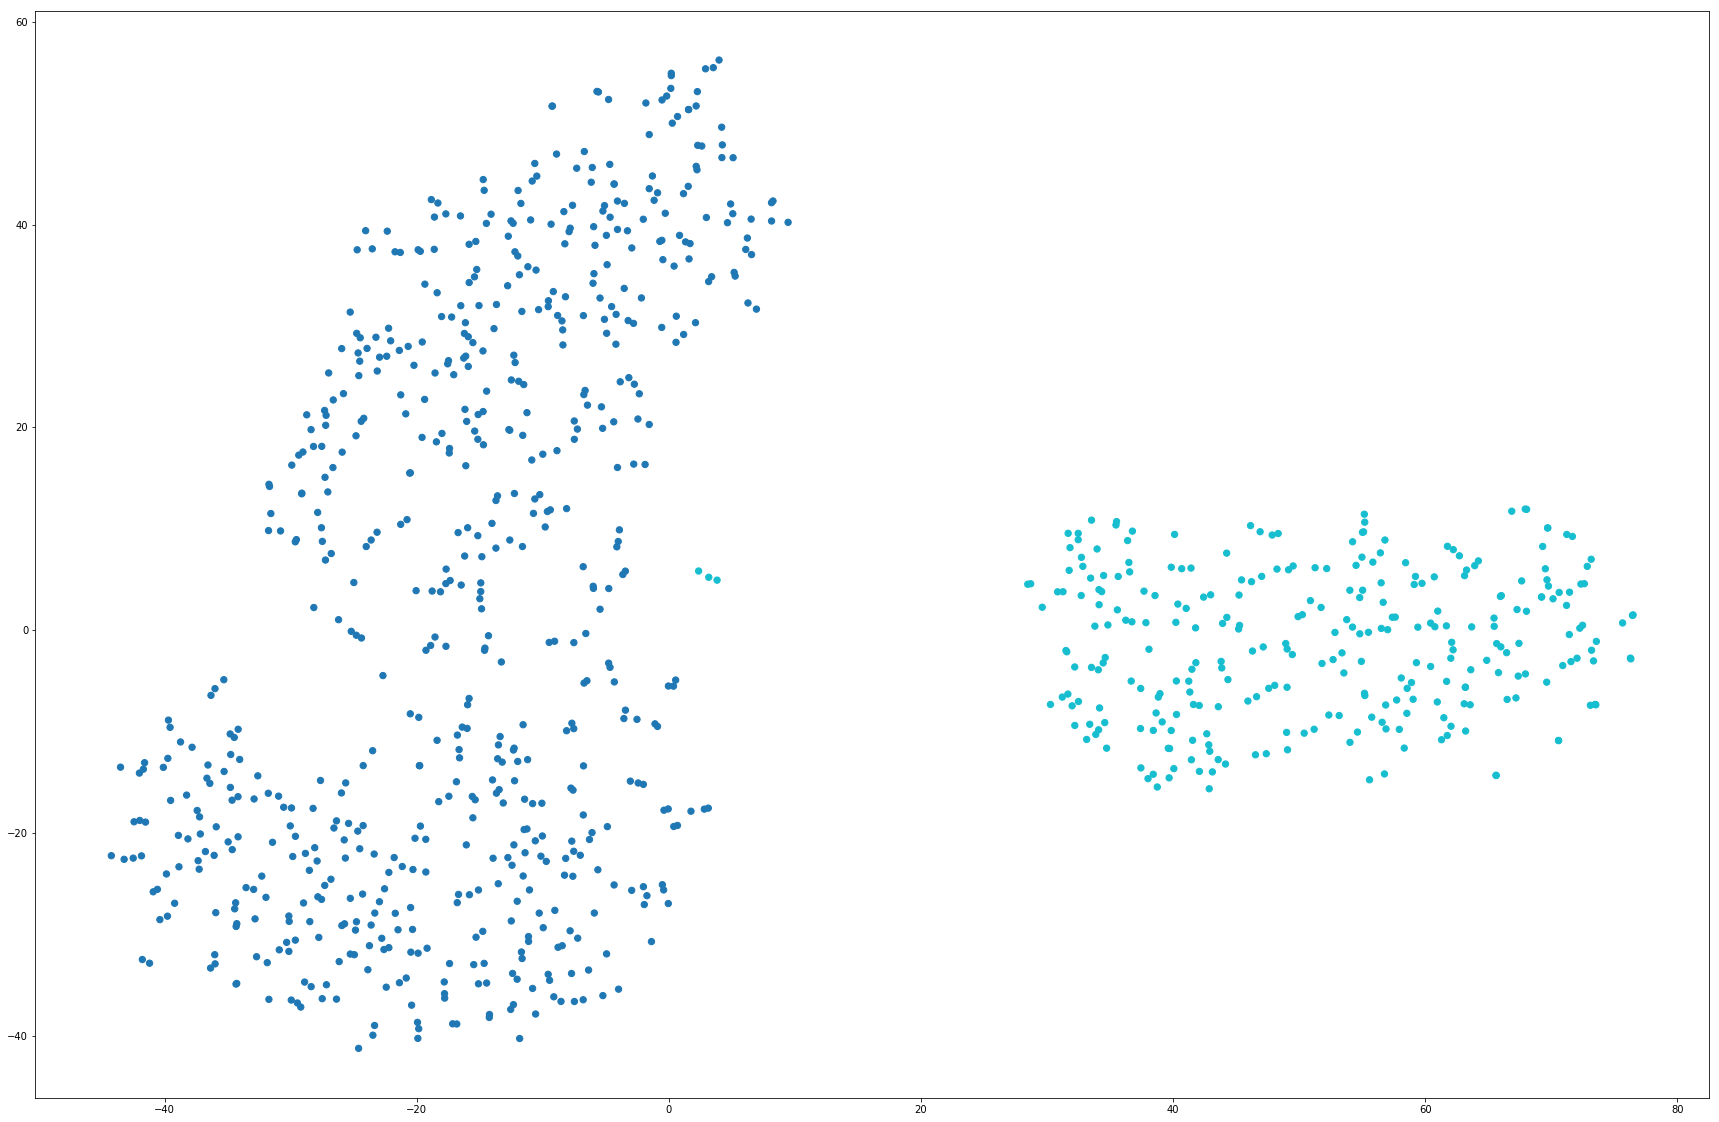

In [16]:
import matplotlib.pyplot as plt

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [17]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("baseline_results.pickle", 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

  0%|          | 0/3768 [00:00<?, ?it/s]

load data


 85%|████████▍ | 3185/3768 [08:12<01:32,  6.33it/s]


{'ap': array([0.46649906, 0.35460635]), 'map': 0.4105527015235588}


In [18]:
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("mahal_result.pickle", "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open("mahal_result.pickle", "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)



 85%|████████▍ | 3185/3768 [08:55<01:40,  5.79it/s]


{'ap': array([0.45002324, 0.30613546]), 'map': 0.3780793497966968}


[[125.05642  426.87784  180.98584  452.91373 ]
 [174.04262  346.02374  267.54318  376.80243 ]
 [ 30.103912 258.87677  173.3797   363.2055  ]]
[0 0 0]
[ 22.90953   92.318085 102.73608 ]


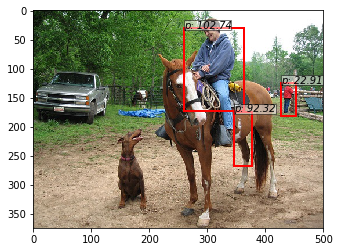

In [19]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

print(_bboxes[0])
print(_labels[0])
print(_scores[0])

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0].reshape(-1)),
         at.tonumpy(_scores[0].reshape(-1)))

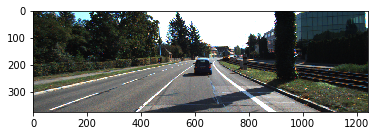

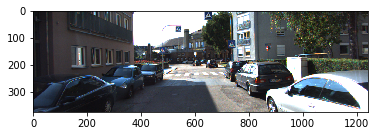

In [20]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Do some predictions of "weird car" images from Google

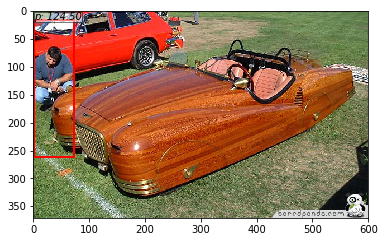

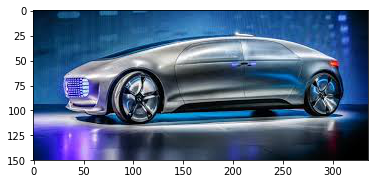

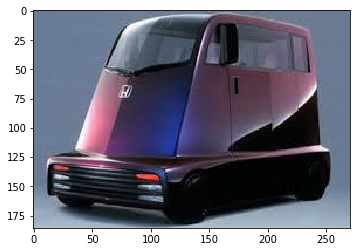

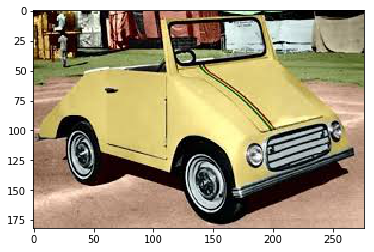

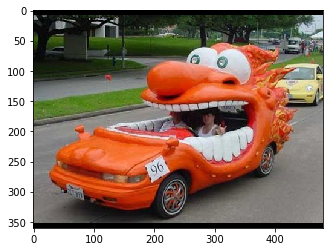

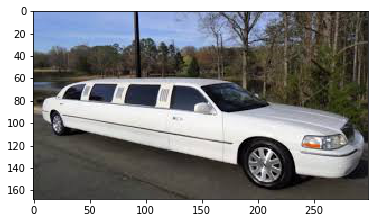

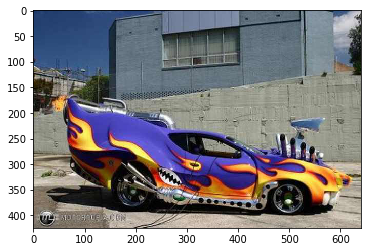

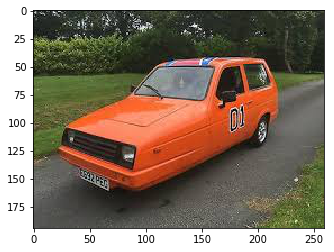

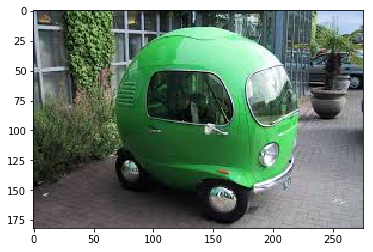

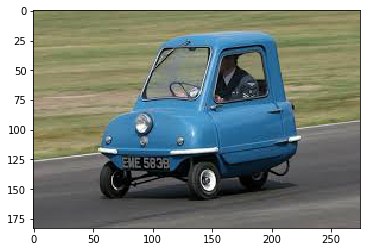

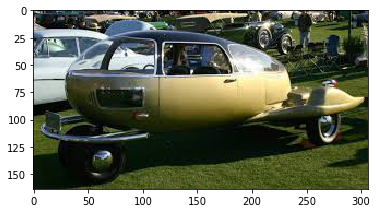

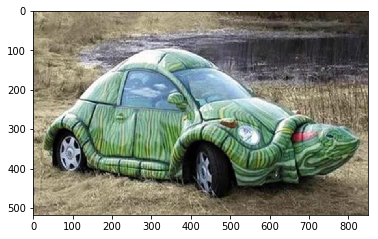

In [21]:
for img_name in os.listdir("./weird_cars"):
    img_path = os.path.join("./weird_cars", img_name)
    im = np.array(read_image(img_path))
    
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis([im], visualize=True)
    
    vis_bbox(at.tonumpy(im),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# AUROC Mahalanobis on test data

In [22]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [66]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict_mahalanobis(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test.pickle", "rb") as f:
        gt_bboxes= pickle.load(f)
    with open("gt_labels_test.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test.pickle", "rb") as f:
        pred_scores = pickle.load(f)

100%|██████████| 3185/3185 [08:57<00:00,  5.17it/s]


In [67]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    ious = bbox_iou(np.array([bbox]), gt_boxes)
    best_iou = np.max(ious)
    best_label = gt_labels[np.argmax(ious)]
    
    return best_iou, best_iou > 0 and best_label == label
            

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
        
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 9069
Pred bboxes: 4514


In [77]:
from itertools import chain
from metrics import barcode_plot, fpr_at_95_tpr, auroc, detection_error

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.18814206609875084
Class 0.27355332824479106
Both 0.15313184641541705

FPR@95TPR
Overlap 0.9984108065156932
Class 0.9994742376445847
Both 0.9986149584487535

Detection Err
Overlap 0.5164813171286529
Class 0.5246222643046813
Both 0.5205251914014986


/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


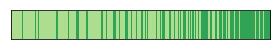

In [79]:
from metrics import barcode_plot, fpr_at_95_tpr, auroc
barcode_plot([-a for a in scores], both_correct)

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


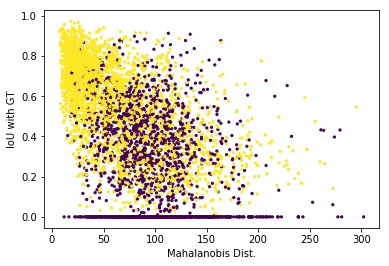

In [85]:
# Mahalanobis score vs IoU vs correct classificationplt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("IoU with GT")
plt.show()

# AUROC Max Softmax on test data

In [86]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [87]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test_softmax.pickle", "rb") as f:
        gt_bboxes = pickle.load(f)
    with open("gt_labels_test_softmax.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test_softmax.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test_softmax.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test_softmax.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test_softmax.pickle", "rb") as f:
        pred_scores = pickle.load(f)

100%|██████████| 3185/3185 [08:25<00:00,  6.68it/s]


In [88]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))

# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
        
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 9069
Pred bboxes: 4514


In [89]:
from itertools import chain
from sklearn.metrics import roc_auc_score

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.8060689564342541
Class 0.7673654555614065
Both 0.8722422681290526

FPR@95TPR
Overlap 0.8061183949145808
Class 0.8438485804416404
Both 0.6336565096952909

Detection Err
Overlap 0.4278463782284471
Class 0.44661801150719077
Both 0.3417360039251362


/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


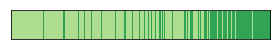

In [90]:
from metrics import barcode_plot
barcode_plot(scores, both_correct)

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


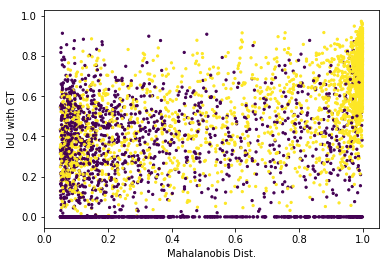

In [91]:
# Softmax score vs IoU vs correct classification
plt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Max Softmax")
plt.ylabel("IoU with GT")
plt.show()

In [92]:
with open("pred_scores_test_softmax.pickle", "rb") as f:
    softmax_scores = pickle.load(f)
    softmax_scores = list(chain(*softmax_scores))
        
with open("pred_scores_test.pickle", "rb") as f:
    mahal_scores = pickle.load(f)
    mahal_scores = list(chain(*mahal_scores))

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


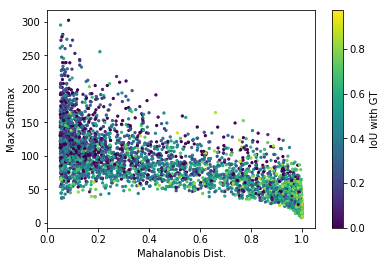

In [99]:
# Mahalanobis score vs Softmax score vs IoU
plt.figure()
plt.scatter(softmax_scores, mahal_scores, c=list(chain(*bboxes_ious)), cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("Max Softmax")
leg = plt.colorbar()
leg.set_label("IoU with GT")
plt.show()